In [245]:
import sklearn
import pandas as pd
import numpy as np
import math
from scipy.stats import zscore
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# preproc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV 
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_curve,  precision_recall_curve
from sklearn.metrics import auc,  roc_auc_score, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix 

# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs

# SET GLOBAL
RANDOM = 0
TEST_SIZE = 0.2
KEY_THRESH = 0.35


In [272]:

# custom func
def pretty_confusion_matrix(confmat, filename):

    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', fontsize = 30)
       
    # change the labels
    ax.set_xticklabels(['']+['No Mets', 'Mets'])
    ax.set_yticklabels(['']+['No mets', 'Mets'])
    plt.xlabel('Predicted Label', size = 20)
    plt.ylabel('True Label', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks (fontsize = 20)
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

## 1. Prep data

- load data 
- one-hot encode categorical features
- standard scale (zscore) continuous features
- split data into train-val and hold-out test sets 
- stratified CV folds, 5 folds repeated 5x with random sampling

In [95]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_N924.csv")
outcome = df['metastasis']
features = df.drop(columns =['metastasis'])

features['AGE'] = features.AGE.astype('float')
features['tumor_site'] = features.tumor_site.astype("category")
features.dtypes

AGE                     float64
SEX                       int64
tumor_size_bins_cm      float64
tumor_site             category
immuno_suppressed         int64
tumor_lymphocytes         int64
lymph_vasc_invasion     float64
tumor_depth             float64
dtype: object

In [96]:
# DEFINE PREPROCESSING 
#numerical_features = features.dtypes == 'float'
#categorical_features = ~numerical_features

#preprocess = make_column_transformer(
 #   (numerical_features, StandardScaler()),
 #   (categorical_features, OneHotEncoder())
#)
#preprocess.fit_transform(features)

In [97]:
# preprocessing outside pipeline for now.
one_hot_tumor_site = pd.get_dummies(features['tumor_site'], prefix =  "tumor_site")
features = features.drop(columns = ['tumor_site'])
features = pd.concat([features, one_hot_tumor_site], axis = 1)

# standardized continuous features
features['AGE'] = zscore(features.AGE, ddof=1)
features['tumor_depth'] = zscore(features.tumor_depth, ddof = 1)
features['tumor_size_bins_cm'] = zscore(features.tumor_size_bins_cm, ddof=1)


In [98]:
# split into train-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
# make cross val folds
CV_folds =  RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats =  5,  
                                    random_state = 0)

## 2. Set up models 
###  Logistic Regression Variants
Testing three linear logistic reg variants: 
- L1 regularization = lasso (coefficients shrunk to zero, feature selection)
- L2 regularization = ridge (coefficients shrink to tiny sizes) *default l2, C = 0.1*
- elastic net = best of both 

Other notes:
- Solver = 'saga' because it supports all 3 model types
- Maintaining the balanced weights moving forward
- increasing max number of iterations to 1000 so models converge

### SVM
- because why not 
- need a better reason here.

### Random forest
- allows for non-linear interactions between features
- might have advantage given bootstrap sampling...
- usually just does better.

In [99]:
# DEFINE MODELS 
Lasso_L1 = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                             penalty = 'l1', 
                              solver = 'saga', 
                             random_state = RANDOM)
Ridge_L2 = LogisticRegression(class_weight = 'balanced',
                              max_iter = 1000,
                              penalty = 'l2', 
                              solver = 'saga',  
                             random_state =  RANDOM)
Elastic_net = LogisticRegression(class_weight = 'balanced', 
                                 penalty = 'elasticnet',
                                 solver = 'saga', 
                                 l1_ratio = 0.01,
                                 max_iter = 1000, 
                                 random_state = RANDOM)
SVM = SVC (kernel = "rbf",
          class_weight = 'balanced',
          probability = True,
          random_state = RANDOM)

RF = RandomForestClassifier(class_weight = 'balanced',
                           random_state = RANDOM)

In [100]:
# DEFINE PIPELINES (not actually using yet)
# - add preproc later.
Lasso_pipe = Pipeline([('model', Lasso_L1)])
Ridge_pipe = Pipeline([('model', Ridge_L2)])
Elastic_pipe = Pipeline([('model', Elastic_net)])
SVM_pipe = Pipeline([('model', SVM)])
RF_pipe = Pipeline([('model', RF)])

In [101]:
## DEFINE SCORES 
score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
               'f1': 'f1',
              'roc_auc': 'roc_auc'}

## 3.  Fit models with grid search  CV

#### 3.1 Define hyper-parameters
For linear models 
- tuning the amount of penalization / lambda/ C
- larger C = less regularization
- smaller C = more regularization (more coefficients to zero)
- default Logistic Regression in sklearn has C = 0.1, l2 regularization (ridge)

For Random forest
- tuning minimum samples per leaf 
- controls tree depth

In [223]:
# larger C = less regularization
# default = 1.0 
param_grid_C = {'C': [0.001, 0.01, 0.1, 1, 10] }
param_grid_RF = {'min_samples_leaf' : [1,2,3,4,5]}

In [154]:

Lasso_grid = GridSearchCV(Lasso_L1,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

Ridge_grid = GridSearchCV(Ridge_L2,
                    param_grid = param_grid_C,                    
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

Elastic_grid = GridSearchCV(Elastic_net,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

SVM_grid = GridSearchCV(SVM,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

RF_grid = GridSearchCV(RF,
                    param_grid = param_grid_RF,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

#### 3.2  Run loop for each classification grid

In [224]:

# list of names
classifier_names = ['Lasso Regression', 'Ridge Regression', 
                   'Elastic net', 'Support Vector Machine',
                   'Random Forest']
# list of pipelines for each model
classifiers = [Lasso_grid, Ridge_grid, Elastic_grid, 
               SVM_grid, RF_grid]

# fit each grid and save metrics.
i = 0
grid_results = pd.DataFrame()
for classifier in classifiers:
    classifier.fit(X_trainval, y_trainval)
    # get the results and store them!
    results = pd.DataFrame(classifier.cv_results_)
    results['model'] = classifier_names[i]
    print(classifier_names[i])
    print(results.shape)
    i = i + 1
    grid_results = pd.concat([grid_results, results], ignore_index = True)
    


Lasso Regression
(5, 282)
Ridge Regression
(5, 282)
Elastic net
(5, 282)
Support Vector Machine
(5, 282)
Random Forest
(5, 282)


#### 3.3 Get grid search CV model results 

In [156]:
# get log  of C for easier visualization
grid_results['param_C']= grid_results.param_C.astype('float')
grid_results['log_C'] = grid_results.param_C.map(lambda x: math.log(x))
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'params', 'split0_test_acc', 'split1_test_acc',
       'split2_test_acc', 'split3_test_acc',
       ...
       'split20_train_roc_auc', 'split21_train_roc_auc',
       'split22_train_roc_auc', 'split23_train_roc_auc',
       'split24_train_roc_auc', 'mean_train_roc_auc', 'std_train_roc_auc',
       'model', 'param_min_samples_leaf', 'log_C'],
      dtype='object', length=284)

In [176]:
# compile results into neater format

grid_results = grid_results[['model', 'param_C', 'log_C', 'param_min_samples_leaf',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc']]
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['model', 'param_C', 'log_C', 'param_min_samples_leaf'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                         'mean_train_roc_auc', 'mean_test_roc_auc'], 
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")


,model,param_C,log_C,param_min_samples_leaf,metric,score,dataset
0,Lasso Regression,0.001,-6.907755,NaN,mean_train_f1,0.217883,Train
1,Lasso Regression,0.010,-4.605170,NaN,mean_train_f1,0.297013,Train
2,Lasso Regression,0.100,-2.302585,NaN,mean_train_f1,0.501126,Train
3,Lasso Regression,1.000,0.000000,NaN,mean_train_f1,0.514503,Train
4,Lasso Regression,10.000,2.302585,NaN,mean_train_f1,0.516143,Train


In [209]:
# chunk by metric 
accuracy_results =  grid_results_long[(grid_results_long.metric == "mean_test_acc") | 
                                    (grid_results_long.metric == "mean_train_acc")]

recall_results = grid_results_long[(grid_results_long.metric == "mean_test_recall") | 
                                    (grid_results_long.metric == "mean_train_recall")]

precision_results = grid_results_long[(grid_results_long.metric == "mean_test_precision") | 
                                    (grid_results_long.metric == "mean_train_precision")]

f1_score_results = grid_results_long[(grid_results_long.metric == "mean_test_f1") | 
                                    (grid_results_long.metric == "mean_train_f1")]
roc_auc_score_results = grid_results_long[(grid_results_long.metric == "mean_test_roc_auc") | 
                                    (grid_results_long.metric == "mean_train_roc_auc")]

random_forest_results = grid_results_long[grid_results_long.model == "Random Forest"]
random_forest_results.head()

,model,param_C,log_C,param_min_samples_leaf,metric,score,dataset
20,Random Forest,NaN,NaN,1,mean_train_f1,0.996497,Train
21,Random Forest,NaN,NaN,2,mean_train_f1,0.901878,Train
22,Random Forest,NaN,NaN,3,mean_train_f1,0.809055,Train
23,Random Forest,NaN,NaN,4,mean_train_f1,0.751656,Train
24,Random Forest,NaN,NaN,5,mean_train_f1,0.715809,Train


### 3.4 Inspect learning curves  
comparing train vs. validation scores across grid search CV
- we can see that changing value of C makes a big difference for lasso and SVM, but not the other two models.

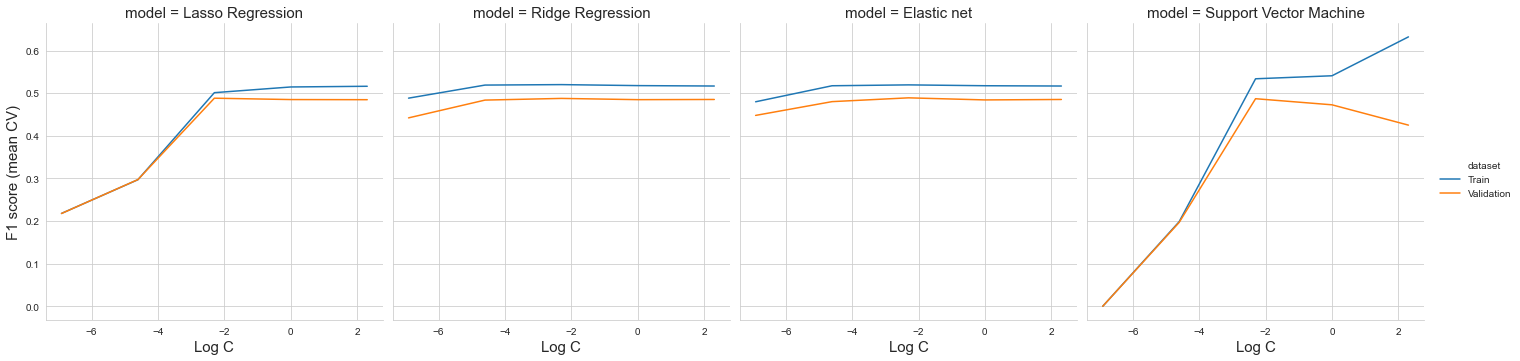

In [180]:
# figure of model comparisons on training  
g = sns.relplot(data = f1_score_results[f1_score_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("F1 score (mean CV)", size = 15)
g.set_titles(size = 15)
plt.savefig('../figures/NCDB_8_features_results/grid_CV_f1_Score.png', bbox_inches = 'tight')

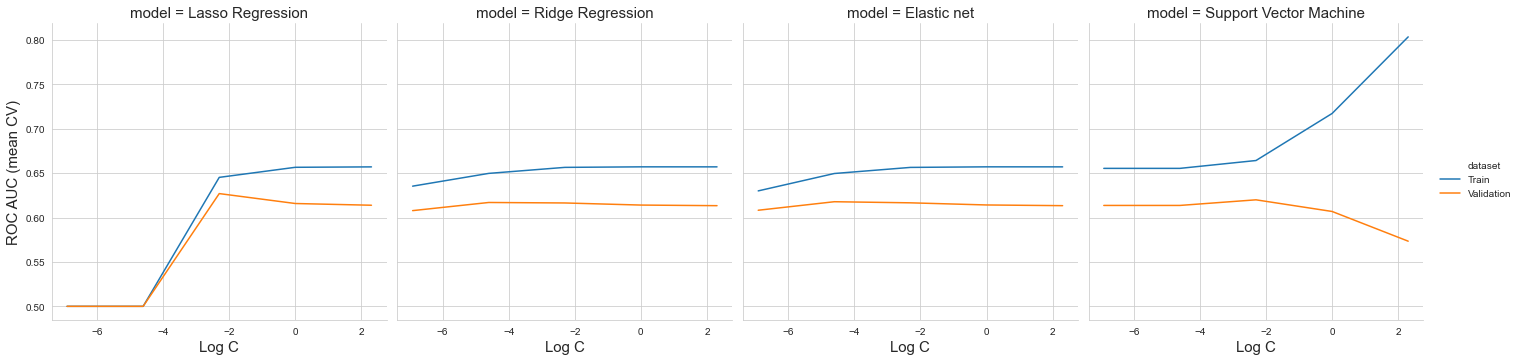

In [202]:
# figure of model comparisons on training  
g = sns.relplot(data = roc_auc_score_results[roc_auc_score_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("ROC AUC (mean CV)", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_8_features_results/grid_CV_roc_auc.png', bbox_inches = 'tight')

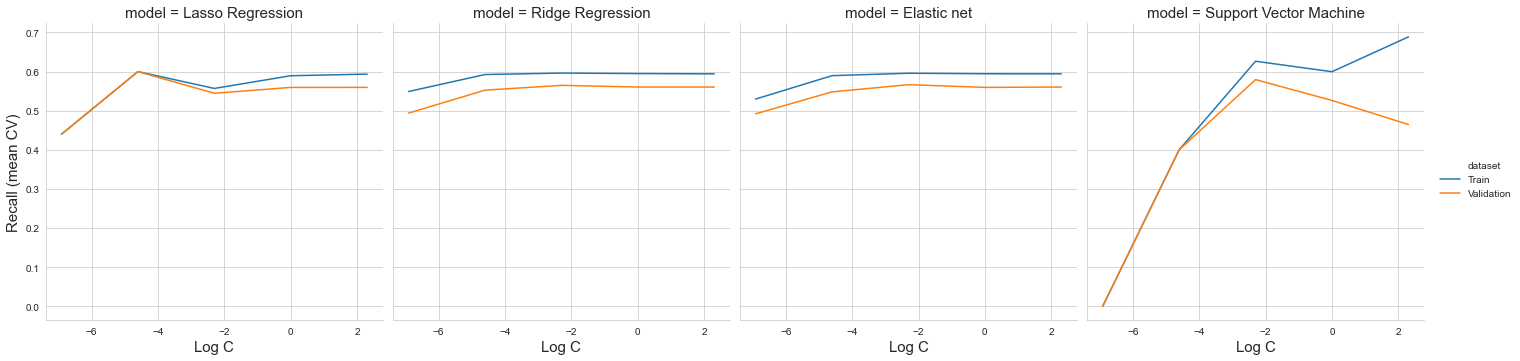

In [267]:
# figure of model comparisons on training  
g = sns.relplot(data = recall_results[recall_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Recall (mean CV)", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_8_features_results/grid_CV_recall.png', bbox_inches = 'tight')

#### random forest has  an over-fitting problem!! 

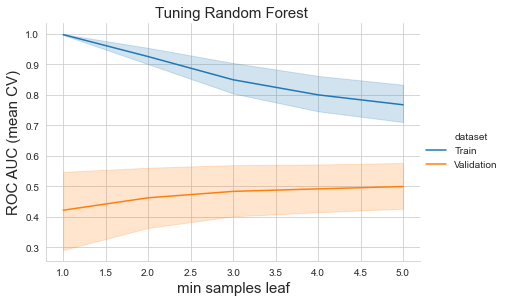

In [212]:
g = sns.relplot(data = random_forest_results,
                x = "param_min_samples_leaf", y = "score", 
                 hue = "dataset", kind = "line", 
                height =  4, aspect = 1.5)
g.set_xlabels("min samples leaf", size = 15)
g.set_ylabels("ROC AUC (mean CV)", size = 15)
plt.title("Tuning Random Forest ", size = 15);
#g.set(xlim=(1,5), ylim=(.4, .7))


### 3.5 Compare model performance on validation sets

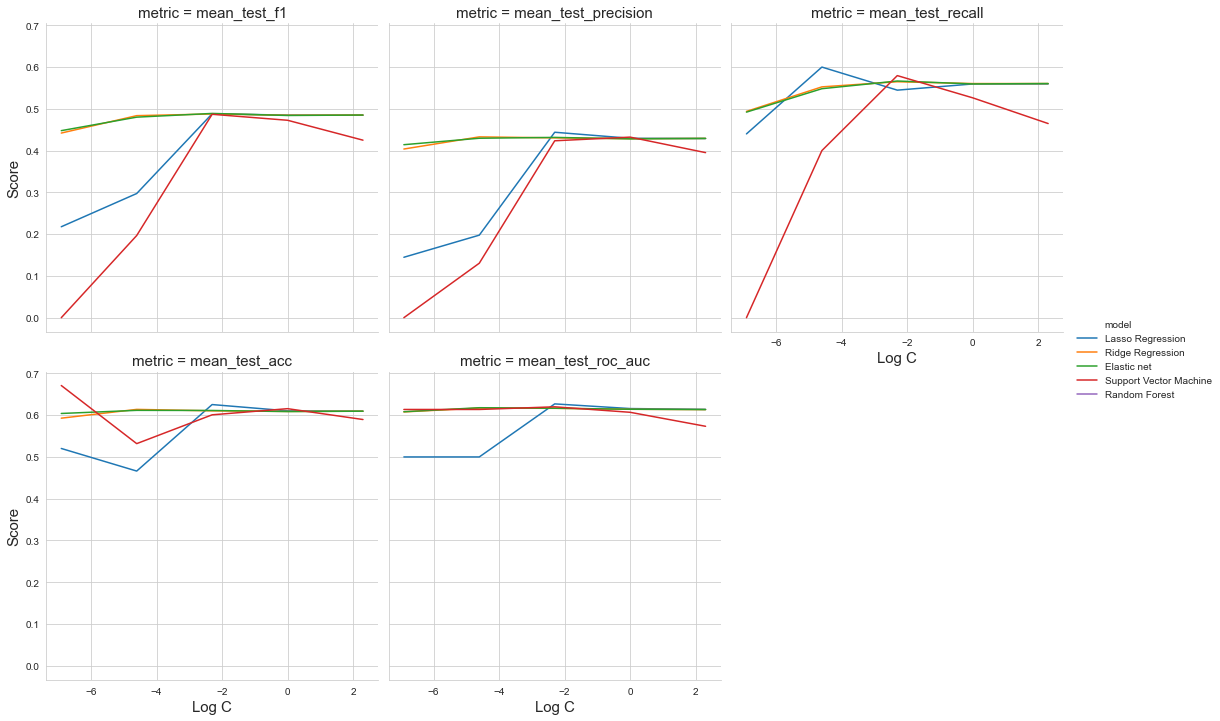

In [246]:
g = sns.relplot(data = grid_results_long[grid_results_long.dataset == "Validation"], 
                x = "log_C", y = "score", 
                hue = "model", col = "metric",
                kind = "line", col_wrap = 3)
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Score", size = 15)
g.set_titles(size = 15)

In [ ]:
### 3.4 Compare models on ROC curve 

# plot 
plt.figure(figsize = (10, 6))
plt.step(recall, precision,  where='post',  color = "blue",
    label='PR AUC for NCDB 8 features = %0.2f'% auc_score)
plt.plot(recall[thresh_lower], precision[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.35", mew = 3, color = "red")
plt.plot(recall[thresh_default], precision[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "orange")
plt.xlabel('Recall', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve on Test Set', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/NCDB_8_features_results/PR_curve_model_comparisons.png")
plt.show()

## 4. Evaluate the best model
- fit the final model, with all of the training data
- run on hold-out test data.

### 4.1 find best model from all grids
- using ROC AUC as criterion

In [226]:
best_metric = grid_results['mean_test_roc_auc'].max()
best_model = pd.DataFrame(grid_results[grid_results['mean_test_roc_auc']== best_metric])

print("Best Recall: {}".format(best_metric.round(2)))
print("Best model: {}".format(best_model['model']))
print("Best C parameter: {}".format(best_model['param_C']))


Best Recall: 0.63
Best model: 2    Lasso Regression
Name: model, dtype: object
Best C parameter: 2    0.1
Name: param_C, dtype: object


###  4.2 Fit the best model on test data

In [277]:
# define and fit the model 
best_LR_model = LogisticRegression(class_weight = 'balanced', max_iter = 1000,
                                       penalty = 'l1', solver = 'saga',
                                        C = 0.1)

best_LR_model.fit(X_trainval, y_trainval)

# get predictions
y_pred = best_LR_model.predict(X_test)
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(X_test))[1]

from sklearn.metrics import fbeta_score
# get scores 
best_test_scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc", "f1",  "accuracy"],
                            "score" : [precision_score(y_test, y_pred), 
                                        recall_score(y_test, y_pred),
                                         roc_auc_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred), 
                                        fbeta_score(y_test, y_pred, beta = 0.5)]
                           })
best_test_scores['score'] = test_scores.scores.round(3)

print("Best Model scores on hold-out test set")
display(best_test_scores)

Best Model scores on hold-out test set


,metrics,score
0,precision,0.506
1,recall,0.600
2,roc_auc,0.659
3,f1,0.680
4,accuracy,0.522


### 4.3 Inspect the confusion matrix


In [278]:
# get our predictions on the test dataset for conversion = 1 or 0

cm = confusion_matrix(y_test, y_pred)
pretty_confusion_matrix(cm, "../figures/NCDB_8_features_results/confusion_matrix_0.5.png")

TypeError: pretty_confusion_matrix() missing 1 required positional argument: 'filename'

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


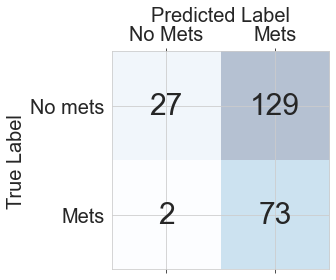

In [273]:
key_thresh = 0.40
y_pred_thresh_lower = y_pred_prob >  key_thresh
cm = confusion_matrix(y_test, y_pred_thresh_lower)
pretty_confusion_matrix(cm, "../figures/NCDB_8_features_results/confusion_matrix_0.4.png")


In [276]:
true_negatives = cm[0,0]
false_negatives = cm[1,0]
true_positives = cm[1,1]
false_positives = cm[0,1]
total_cases = y_test.shape[0]
true_negative_rate =  (true_negatives / total_cases) * 100
false_negative_rate = (false_negatives / total_cases) * 100
false_positive_rate = (false_positives / total_cases) * 100
true_positive_rate =  (true_positives / total_cases) * 100 
print("True negatives: Patients with low risk, no biopsy: {}%".format(round(true_negative_rate,2)))
print("False negatives: Patients mis-classified as low risk, need biopsy: {}%".format(round(false_positive_rate)))
print("True positives: Patients identified as high risk, need biopsy: {}%".format(round(true_positive_rate)))
print("False positives: Patients identified as high risk, but don't need biopsy: {}%".format(round(false_positive_rate)))

True negatives: Patients with low risk, no biopsy: 11.69%
False negatives: Patients mis-classified as low risk, need biopsy: 56%
True positives: Patients identified as high risk, need biopsy: 32%
False positives: Patients identified as high risk, but don't need biopsy: 56%


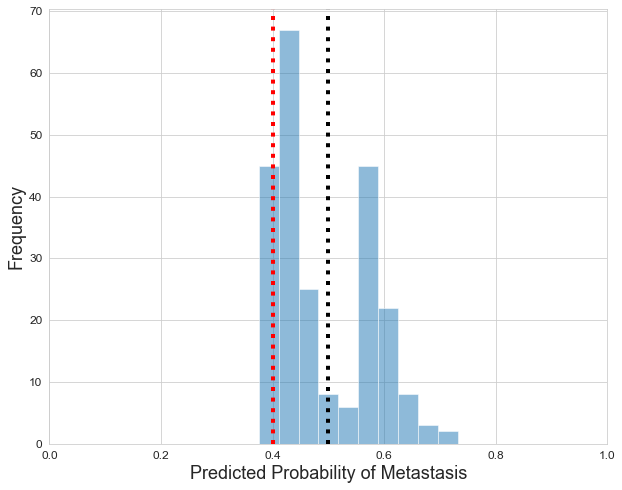

In [268]:
plt.figure(figsize = (10, 8))
plt.hist(y_pred_prob, alpha = 0.5)
plt.axvline(linewidth = 4, color = "red", linestyle = "dotted", x = key_thresh)
plt.axvline(linewidth = 4, color = "black", linestyle = "dotted", x = 0.5)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 1)
plt.xlabel("Predicted Probability of Metastasis", size = 18)
plt.ylabel ("Frequency",  size = 18)
plt.savefig("../figures/NCDB_8_features_results/PredProb_NCDB_8_features.png")
plt.show()


### 4.4 ROC curves 

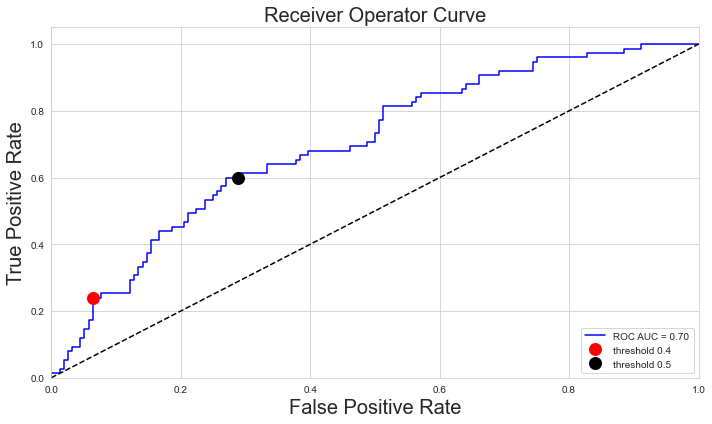

In [286]:
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)
# get thresh
thresh_lower = np.argmin(np.abs(thresh - 0.6))
thresh_default = np.argmin(np.abs(thresh - 0.5))

# plot 
plt.figure(figsize = (10,6))
plt.step(fpr, tpr,  where='post',  color = "blue",
    label='ROC AUC = %0.2f'% auc_score)
plt.plot(fpr[thresh_lower], tpr[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.4", mew = 3, color = "red")
plt.plot(fpr[thresh_default], tpr[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "black")
plt.plot([0,1], [0,1], color = "black", linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver Operator Curve', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/NCDB_8_features_results/ROC_curve.png")

    

### 4.5 PR curves

In [287]:
precision, recall, thresh = precision_recall_curve(y_test, y_pred_prob)
pr_auc_score = auc(recall, precision)
# get thresh
thresh_lower = np.argmin(np.abs(thresh - 0.6))
thresh_default = np.argmin(np.abs(thresh - 0.5))


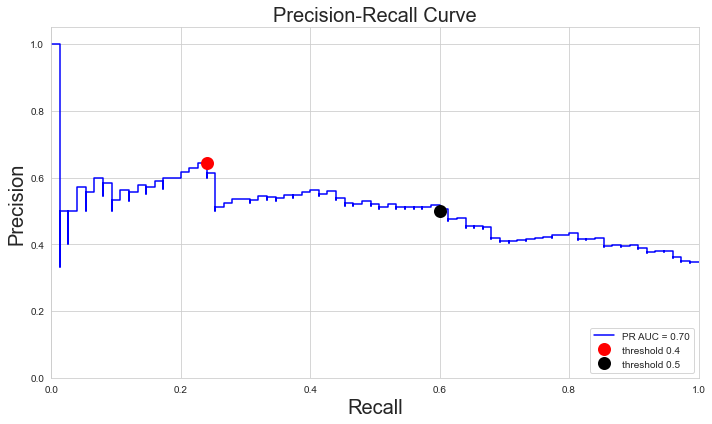

In [291]:

plt.figure(figsize = (10, 6))
plt.step(recall, precision,  where='post',  color = "blue",
    label='PR AUC = %0.2f'% auc_score)
plt.plot(recall[thresh_lower], precision[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.4", mew = 3, color = "red")
plt.plot(recall[thresh_default], precision[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "black")
plt.xlabel('Recall', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/NCDB_8_features_results/PR_Curve.png")


### 4.6 Feature importance

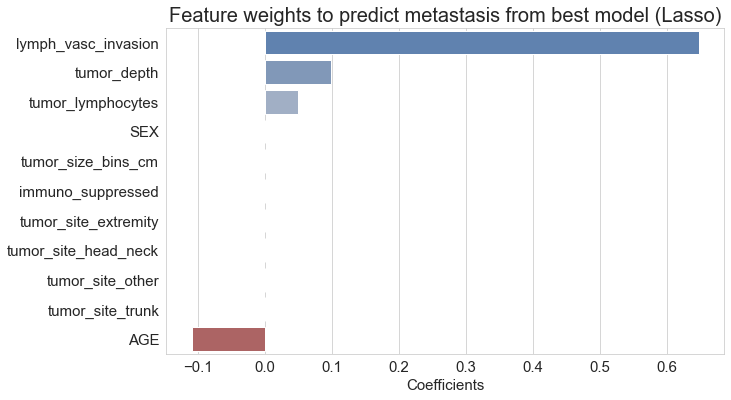

In [238]:
coefs_df = custom_funcs.get_coefs(best_LR_model, X_test)

n_features =  coefs_df.shape[0]
plt.figure(figsize =  (10,6))
g = sns.barplot(data = coefs_df, y = 'features', x = "coefs",
            palette = sns.color_palette("vlag", n_features))
g.set_ylabel("")
g.tick_params(labelsize = 15)
g.set_xlabel("Coefficients", size = 15)
g.set_title("Feature weights to predict metastasis from best model (Lasso)", size = 20);
plt.savefig('../figures/NCDB_8_features_results/best_LR_feature_weights.png', bbox_inches = 'tight')